ELVES paper: https://iopscience.iop.org/article/10.3847/1538-4357/ac6fd7/meta#apjac6fd7t9

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, hstack, vstack

In [3]:
import kuaizi as kz

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

Table 4: Basic Parameters

In [5]:
cat = Table.read('./Catalog/ELVES/elves_sat.txt', 
                  format='ascii.fixed_width_no_header',
                 col_starts=(0, 15, 23, 32, 41, 47, 53, 58, 64, 69, 76,
                             83, 88, 94, 99, 105, 110, 118, 124, 130, 
                             136, 141, 146, 156),
                 )
new_cols = ['name', 'host', 'RA', 'Dec', 'Rproj', 'gmag', 'e_gmag', 
            'rimag', 'e_rimag', 'Mgmag', 'MVmag', 'e_MVmag', 'log_m_star', 
            'e_log_m_star', 'mu0V', 'e_mu0V', 're', 'e_re', 'ETG', 'Confirmed', 'Psat', 'Filt', 'Tel', 'Bad']

cat.rename_columns(cat.colnames, new_cols)

secure = (cat['Psat'] > 0.8)
cat = cat[secure]

In [6]:
len(cat)

351

In [7]:
np.sum(cat['Confirmed'].data == 'True')

338

In [8]:
len(cat)

351

In [9]:
np.unique(cat['host']).shape

(30,)

### Split into Scott's photometry + McConnachie's photometry (only V-band). For the latter, we calculate g-band photometry based on an average g-V from the former part. 

In [10]:
scott_cat = cat[cat['Tel'] != 'MCCONN']
gV = scott_cat['Mgmag'] - scott_cat['MVmag']

In [11]:
np.median(gV), np.mean(gV)

(0.28999999999999915, 0.2771052631578947)

In [12]:
# cat = cat[cat['Tel'] != 'MCCONN']

In [13]:
dist = 10**((cat['gmag'] - cat['Mgmag'] - 25) / 5)
re_ang = 206265 * cat['re'] / dist * 1e-6

In [14]:
SB_eff_g = cat['gmag'] + 2.5 * np.log10(2 * np.pi * re_ang**2)

In [15]:
cat['SB_eff_g'] = SB_eff_g
cat['dist'] = dist

### How many UDGs in how many hosts?

In [50]:
udg_flag = (cat['SB_eff_g'].data.data > 25) | ((cat['Tel'] == 'MCCONN').data & (cat['mu0V'].data.data > 24.3)) # 0.28 for gV
udg_flag &= ((cat['re'].data.data) / 1000 > 1.5) #  + cat['e_re'].data.data
# udg_flag &= cat['log_m_star'] > 6.5
np.sum(udg_flag)

13

In [51]:
11 / 30, np.sqrt(11) / 30

(0.36666666666666664, 0.11055415967851333)

In [64]:
11 / np.sum(cat['log_m_star'] > 6.5), 13 / len(cat['log_m_star'])

(0.046218487394957986, 0.037037037037037035)

In [17]:
temp = cat[cat['host'] == 'M81']
temp.sort('mu0V')

In [23]:
cat[udg_flag].write('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/ELVES_UDG_for_Meng.fits')

In [47]:
len(cat[udg_flag])

13

In [48]:
len(np.unique(cat[udg_flag]['host']))

10

In [49]:
11 / 238

0.046218487394957986

In [21]:
np.sqrt(13) / 30

0.1201850425154663

In [56]:
13 / 351, np.sqrt(13) / 351

(0.037037037037037035, 0.01027222585602276)

----
### UPGs

In [17]:
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m

In [53]:
upg_flag = cat['re'] > 10**(mass_size_carlsten(cat['log_m_star']).data + 1.5 * 0.181)

In [54]:
flag = (np.log10(cat['re']) - mass_size_carlsten(cat['log_m_star'])) > 0.181 * 1.5
flag &= cat['log_m_star'] > 6.5

In [55]:
upg_flag = (flag.data & ~flag.mask)

In [56]:
np.sum(upg_flag)

23

In [63]:
23 / np.sum(cat['log_m_star'] > 6.5), 36 / len(cat['log_m_star'])

(0.09663865546218488, 0.10256410256410256)

In [43]:
23 / 351

0.06552706552706553

In [36]:
23 / 30, np.sqrt(23) / 30

(0.7666666666666667, 0.15986105077709065)

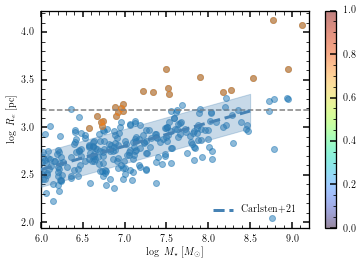

In [30]:
# Carlsten mass-size relation
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m
x = np.linspace(6, 8.5)
plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
                 mass_size_carlsten(x) + 0.181, 
                 color='steelblue', alpha=0.3, zorder=10)
plt.plot(x, mass_size_carlsten(x), ls='--', 
         color='steelblue', lw=3, label='Carlsten+21', zorder=10)

plt.scatter(cat['log_m_star'], 
            np.log10(cat['re']), 
            alpha=0.5, zorder=1)

plt.scatter(cat['log_m_star'][upg_flag], 
            np.log10(cat['re'][upg_flag]), 
            alpha=0.5, zorder=1)

plt.colorbar()

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ R_{e}\ [\rm pc]$')
plt.legend(loc='lower right')

plt.xlim(6., 9.2)

plt.axhline(np.log10(1500), ls='--', color='gray')

In [68]:
23 / 30

0.7666666666666667

In [55]:
len(np.unique(cat[upg_flag]['host']))

20

In [57]:
36 / 351, np.sqrt(35) / 351

(0.10256410256410256, 0.016854928156978963)

In [180]:
36 / 30

1.2

In [33]:
(cat['log_m_star'] > 6.5).sum()

238

In [34]:
23 / 238

0.09663865546218488

In [35]:
23 / 18

1.2777777777777777

In [38]:
len(np.unique(cat[(cat['log_m_star'] > 6.5)]['host']))

30

Therefore, there are 15-20 UDGs in Scott's sample (444 sats in total)

4 bad photometry

Therefore should be 11 - 16 UDGs out of 429 healthy sates

In [50]:
np.sum(cat['Bad'].data.data != 'yes')

429

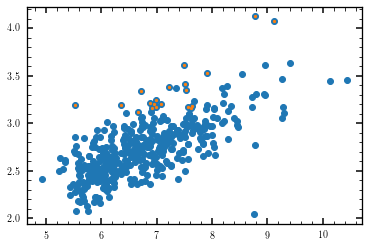

In [35]:
plt.scatter(cat['log_m_star'], np.log10(cat['re']))
plt.scatter(cat[udg_flag]['log_m_star'], np.log10(cat[udg_flag]['re']), s=5)

In [46]:
cat[udg_flag]['Psat'].mean()

0.96

---

### Host

In [97]:
host_cat = Table.read('./Catalog/ELVES/elves_host.txt', 
                      format='ascii.tab'
                 )
host_cat

Name,Dist,v _rec,${M}_{{K}_{s}}$,${M}_{{K}_{s}}^{\mathrm{group}}$,M _V,B - V,$\mathrm{log}({M}_{\star }/{M}_{\odot })$,r _cover,Data Source,References,col11
str8,float64,int64,float64,float64,float64,float64,float64,int64,str18,str27,int64
M31,0.78,-300,-24.81,-24.89,-21.19,0.87,11.01,300,M12,"CF, RC3, Sick15",--
NGC 253,3.56,259,-23.95,-23.96,-20.7,0.94,10.77,300,D- -D,"CF, Cook14a, Cook14b",--
NGC 628,9.77,656,-22.79,-22.81,-20.68,0.48,10.45,300,D-G-D,"CF, Cook14a, Cook14b",--
NGC 891,9.12,528,-23.83,-23.83,-20.05,0.82,10.84,200,C-C-C,"CF, GALEX, ${M}_{{K}_{s}}$",--
NGC 1023,10.4,638,-23.78,-23.98,-20.91,0.95,10.6,200,C-C-C,"NED, GALEX, ${M}_{{K}_{s}}$",--
NGC 1291,9.08,838,-23.94,-23.97,-21.01,1.0,10.78,300,"D-D,M-D","CF, Cook14a, Ler19",--
NGC 1808,9.29,1002,-23.12,-23.78,-19.98,0.79,10.01,300,"D-D,G,H,M-D","CF, RC3, Ler19",--
NGC 2683,9.4,409,-23.49,-23.5,-20.17,0.86,10.5,300,D-H-D,"K15, Cook14a, Ler19",--
NGC 2903,9.0,556,-23.68,-23.69,-20.78,0.65,10.67,300,"D-G,C-D","K13&T19, Cook14a, Cook14b",--


In [100]:
host_cat['${M}_{{K}_{s}}$'].data.mean()

-23.593870967741935

In [101]:
host_cat['${M}_{{K}_{s}}$'].data.std()

0.6845986694329649

(array([2., 1., 4., 8., 5., 1., 3., 4., 0., 3.]),
 array([-24.91 , -24.632, -24.354, -24.076, -23.798, -23.52 , -23.242,
        -22.964, -22.686, -22.408, -22.13 ]),
 <BarContainer object of 10 artists>)

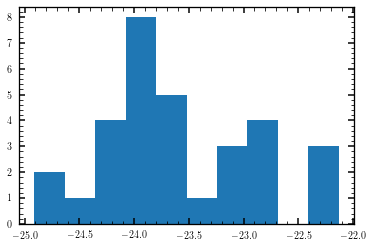

In [99]:
plt.hist(host_cat['${M}_{{K}_{s}}$'].data)

---

### Magellan

In [29]:
flag = ((cat['RA'] / 15 > 15) | (cat['RA'] / 15 < 3)) & (cat['Dec'] < 20)
cat = cat[flag]
flag = (cat['mu0V'].data.data > 24.3) & (cat['re'].data.data > 1.5)
cat = cat[flag]
cat.sort('RA')
cat

name,host,RA,Dec,Rproj,gmag,e_gmag,rimag,e_rimag,Mgmag,MVmag,e_MVmag,log_m_star,e_log_m_star,mu0V,e_mu0V,re,e_re,ETG,Confirmed,Psat,Filt,Tel,Bad
str14,str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,str2,str9,str3
dw0036m2828,NGC253,9.1273,-28.4701,250.4,18.67,0.11,18.47,0.11,-9.08,-9.21,0.11,5.23,0.13,24.39,0.14,311.7,25.8,False,False,0.05,gr,DECALS,--
dw0047m2623,NGC253,11.8939,-26.3898,68.5,18.89,0.11,18.33,0.11,-8.86,-9.19,0.11,5.77,0.14,26.59,0.15,453.9,39.8,True,True,1.0,gr,DECALS,--
dw0050m2444,NGC253,12.5749,-24.7367,51.7,18.22,0.1,17.95,0.1,-9.53,-9.7,0.1,5.53,0.13,27.91,0.13,1539.2,115.0,True,True,1.0,gr,DECALS,--
dw0137p1607,NGC628,24.4156,16.132,71.5,20.2,0.14,19.57,0.13,-9.75,-10.12,0.15,6.24,0.16,25.96,0.21,489.2,64.2,True,True,1.0,gr,DECALS,--
dw0143p1541,NGC628,25.9012,15.6937,284.0,15.75,0.09,15.35,0.09,-14.2,-14.44,0.09,7.62,0.13,24.46,0.11,1437.6,76.0,False,True,1.0,gr,DECALS,--
SGR,MW,283.8292,-30.5453,18.7,--,--,--,--,--,-13.5,0.3,7.52,0.22,25.2,0.3,2616.7,91.8,True,True,1.0,--,MCCONN,--
dw1859m6402,NGC6744,284.8605,-64.0396,179.4,19.67,0.13,19.01,0.12,-10.09,-10.34,0.13,6.05,0.13,24.67,0.18,285.4,31.3,True,False,0.45,gi,DECAM,--
dw1901m6315,NGC6744,285.3732,-63.2594,171.6,17.96,0.1,17.46,0.1,-11.8,-11.99,0.1,6.53,0.12,25.37,0.13,778.2,55.0,True,False,0.95,gi,DECAM,--
dw1903m6405,NGC6744,285.9146,-64.0985,111.2,20.39,0.15,19.86,0.15,-9.37,-9.57,0.16,5.59,0.15,25.29,0.23,240.1,33.4,True,False,0.65,gi,DECAM,--


In [30]:
cat[['RA', 'Dec']]

RA,Dec
float64,float64
9.1273,-28.4701
11.8939,-26.3898
12.5749,-24.7367
24.4156,16.132
25.9012,15.6937
283.8292,-30.5453
284.8605,-64.0396
285.3732,-63.2594
285.9146,-64.0985


In [8]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

from astropy.coordinates import SkyCoord
from astroplan import FixedTarget
from astroplan import Observer
from astroplan.plots import plot_airmass 
observer = Observer.at_site('Las Campanas Observatory', timezone="US/Eastern")

In [31]:
cat

name,host,RA,Dec,Rproj,gmag,e_gmag,rimag,e_rimag,Mgmag,MVmag,e_MVmag,log_m_star,e_log_m_star,mu0V,e_mu0V,re,e_re,ETG,Confirmed,Psat,Filt,Tel,Bad
str14,str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,str2,str9,str3
dw0036m2828,NGC253,9.1273,-28.4701,250.4,18.67,0.11,18.47,0.11,-9.08,-9.21,0.11,5.23,0.13,24.39,0.14,311.7,25.8,False,False,0.05,gr,DECALS,--
dw0047m2623,NGC253,11.8939,-26.3898,68.5,18.89,0.11,18.33,0.11,-8.86,-9.19,0.11,5.77,0.14,26.59,0.15,453.9,39.8,True,True,1.0,gr,DECALS,--
dw0050m2444,NGC253,12.5749,-24.7367,51.7,18.22,0.1,17.95,0.1,-9.53,-9.7,0.1,5.53,0.13,27.91,0.13,1539.2,115.0,True,True,1.0,gr,DECALS,--
dw0137p1607,NGC628,24.4156,16.132,71.5,20.2,0.14,19.57,0.13,-9.75,-10.12,0.15,6.24,0.16,25.96,0.21,489.2,64.2,True,True,1.0,gr,DECALS,--
dw0143p1541,NGC628,25.9012,15.6937,284.0,15.75,0.09,15.35,0.09,-14.2,-14.44,0.09,7.62,0.13,24.46,0.11,1437.6,76.0,False,True,1.0,gr,DECALS,--
SGR,MW,283.8292,-30.5453,18.7,--,--,--,--,--,-13.5,0.3,7.52,0.22,25.2,0.3,2616.7,91.8,True,True,1.0,--,MCCONN,--
dw1859m6402,NGC6744,284.8605,-64.0396,179.4,19.67,0.13,19.01,0.12,-10.09,-10.34,0.13,6.05,0.13,24.67,0.18,285.4,31.3,True,False,0.45,gi,DECAM,--
dw1901m6315,NGC6744,285.3732,-63.2594,171.6,17.96,0.1,17.46,0.1,-11.8,-11.99,0.1,6.53,0.12,25.37,0.13,778.2,55.0,True,False,0.95,gi,DECAM,--
dw1903m6405,NGC6744,285.9146,-64.0985,111.2,20.39,0.15,19.86,0.15,-9.37,-9.57,0.16,5.59,0.15,25.29,0.23,240.1,33.4,True,False,0.65,gi,DECAM,--


In [32]:
cat = cat[-4:]
objs = []
for i in range(len(cat)):
    coord = SkyCoord(cat['RA'][i], cat['Dec'][i], unit='deg')
#     obj = FixedTarget(name=str(cat['viz-id'][i]), coord=coord)
    obj = FixedTarget(name=None, coord=coord)
    objs.append(obj)

In [33]:
cat.sort('mu0V')

In [34]:
cat

name,host,RA,Dec,Rproj,gmag,e_gmag,rimag,e_rimag,Mgmag,MVmag,e_MVmag,log_m_star,e_log_m_star,mu0V,e_mu0V,re,e_re,ETG,Confirmed,Psat,Filt,Tel,Bad
str14,str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,str2,str9,str3
dw1912m6432,NGC6744,288.0953,-64.5419,115.8,19.68,0.13,19.06,0.12,-10.08,-10.32,0.13,5.99,0.13,24.34,0.18,255.0,28.0,True,False,0.4,gi,DECAM,--
dw1859m6402,NGC6744,284.8605,-64.0396,179.4,19.67,0.13,19.01,0.12,-10.09,-10.34,0.13,6.05,0.13,24.67,0.18,285.4,31.3,True,False,0.45,gi,DECAM,--
dw1903m6405,NGC6744,285.9146,-64.0985,111.2,20.39,0.15,19.86,0.15,-9.37,-9.57,0.16,5.59,0.15,25.29,0.23,240.1,33.4,True,False,0.65,gi,DECAM,--
dw1901m6315,NGC6744,285.3732,-63.2594,171.6,17.96,0.1,17.46,0.1,-11.8,-11.99,0.1,6.53,0.12,25.37,0.13,778.2,55.0,True,False,0.95,gi,DECAM,--


In [ ]:
19.68 - 19.06 # dw1912m6432

In [ ]:
19.67 - 19.01 # dw1859m6402

In [ ]:
20.39 - 19.86 # dw1903m6405

In [35]:
cat = cat[:-1]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'UDG observation')

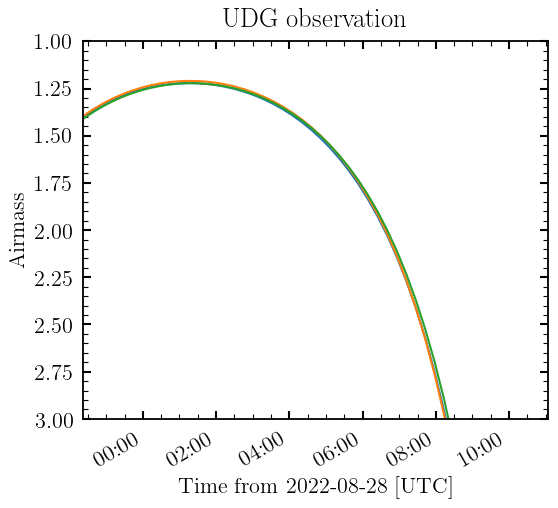

In [36]:
time = Time('2022-08-29 02:00')
sunset_time = observer.sun_set_time(time, which='nearest')
sunrise_time = observer.sun_rise_time(time, which='nearest')

observe_time = sunset_time + np.linspace(0, (sunrise_time - sunset_time).to(u.hour).value, 50) * u.hour

for i in range(len(cat)):
    plot_airmass(objs[i], observer, observe_time,
#                  style_kwargs={'color': colors[i]}, 
                 use_local_tz=True)
# plot_airmass(objs[1], observer, observe_time)
# plot_airmass(objs[2], observer, observe_time)

plt.axvline(23)
plt.legend(shadow=True, loc=2)
plt.title('UDG observation')

In [38]:
cat.write('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/elves_objs.fits', overwrite=True)